In [4]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack, Column
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import datetime


from astropy.io import fits

from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb

from scipy import stats
from scipy.optimize import curve_fit
import scipy.optimize as opt
from multiprocessing import Pool

from scipy.signal import argrelextrema
from scipy.signal import find_peaks

import glob
import lightkurve as lk


from lightkurve.correctors import RegressionCorrector
from lightkurve.correctors import DesignMatrix
from astropy.timeseries import LombScargle

import stella
from tqdm import tqdm_notebook
import os, sys

from stella.download_nn_set import DownloadSets

import celerite2
from celerite2 import terms
from scipy.optimize import minimize

from scipy import integrate
import astropy.units as u

In [5]:
OUT_DIR = 'data'

cnn = stella.ConvNN(output_dir=OUT_DIR)

ds = DownloadSets()
ds.download_models()

MODELS=ds.models

Can only use stella.ConvNN.predict().


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   307  100   307    0     0   1375      0 --:--:-- --:--:-- --:--:--  1376
100 99.5M  100 99.5M    0     0  14.2M      0  0:00:07  0:00:07 --:--:-- 16.6M


hlsp_stella_tess_ensemblemodel_s000_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s001_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s002_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s003_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s004_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s005_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s006_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s007_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s008_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s009_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s010_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s011_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s012_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s013_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s014_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s015_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s016_tess_v0.1.0_cnn.h5
hlsp_stella_tess_ensemblemodel_s017_tess_v0.1.0_cnn.h5
hlsp_stell

In [3]:
search = lk.search_lightcurve(target='tic272272592', mission='TESS', author='SPOC')

lcs=[]

for i in range(len(search)):
    search = lk.search_lightcurve(target='tic272272592', mission='TESS', author='SPOC')
    search.table["dataURL"] = search.table["dataURI"]
    lc = search[i].download().PDCSAP_FLUX
    lc=lc[~np.isnan(lc.flux.value)]
#    lc.plot();

    lcs.append(lc)

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_96954/2824925433.py:8: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_96954/2824925433.py:8: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_96954/2824925433.py:8: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_96954/2824925433.py:8: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_96954/2824925433.

In [4]:
def Stella_Flare_Preds(lc):
    cnn = stella.ConvNN(output_dir=OUT_DIR)
    
    preds = np.zeros((len(MODELS),len(lc)))

    for j, model in enumerate(MODELS):
        cnn.predict(modelname=model,
                    times=lc.time.value,
                    fluxes=lc.flux.value,
                    errs=lc.flux_err.value)
        preds[j] = cnn.predictions[0]

    avg_pred = np.nanmedian(preds, axis=0)
    
    fig=plt.figure()
    plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, label=('Sector'+str(lc.sector)))
    plt.xlabel('Time [BJD-2457000]')
    plt.ylabel('Normalized Flux')
    plt.colorbar(label='Probability')
    plt.legend()
    plt.subplots_adjust(right=1.5)
    plt.show()
    plt.close(fig)

    return avg_pred

In [5]:
def find_flares(lc, pred, threshhold=0.3, min_flare_points=3):
    x = lc.time.value
    y = lc.flux.value

    yerr= lc.flux_err.value
    
    bool_above_thresh= pred > threshhold


    where_flips = [y-x for x, y in zip(np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0], np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][1:])]
    where_flips

    where_flips.insert(0, np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][0])
    where_flips.append(len(bool_above_thresh)-np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][-1])

    falses_lens=where_flips[::2]

    trues_lens=where_flips[1::2]
    
    new_flare_boolean=[]

    for i in range(len(falses_lens)-1):
        if falses_lens[i] > 20:
            new_flare_boolean.append([False for i in range(falses_lens[i])])
            new_flare_boolean.append([True for i in range(trues_lens[i])])
        else:
            new_flare_boolean.append([True for i in range(falses_lens[i])])
            new_flare_boolean.append([True for i in range(trues_lens[i])])

    new_flare_boolean.append([False for i in range(falses_lens[-1])])

    new_bool=np.array([item for sublist in new_flare_boolean for item in sublist])
    

    new_where_flips = [y-x for x, y in zip(np.where(new_bool[:-1] != new_bool[1:])[0], np.where(new_bool[:-1] != new_bool[1:])[0][1:])]
    new_where_flips

    new_where_flips.insert(0, np.where(new_bool[:-1] != new_bool[1:])[0][0])
    new_where_flips.append(len(new_bool)-np.where(new_bool[:-1] != new_bool[1:])[0][-1])

    new_falses_lens=new_where_flips[::2]

    new_trues_lens=new_where_flips[1::2]
    
    start_and_stops=[x for x, y in zip(np.where(new_bool[:-1] != new_bool[1:])[0], np.where(new_bool[:-1] != new_bool[1:])[0][1:])]

    starts=start_and_stops[::2]
    stops=start_and_stops[1::2]
    stops.append(starts[-1]+1)
    
    #Only selecting where the length of the flare is greater than 3 data points

    v2_flare_boolean=[]

    for i in range(len(new_falses_lens)-1):
        if new_trues_lens[i] > min_flare_points:
            v2_flare_boolean.append([False for i in range(new_falses_lens[i])])
            v2_flare_boolean.append([True for i in range(new_trues_lens[i])])
        else:
            v2_flare_boolean.append([False for i in range(new_falses_lens[i])])
            v2_flare_boolean.append([False for i in range(new_trues_lens[i])])

    v2_flare_boolean.append([False for i in range(new_falses_lens[-1])])

    v2_bool=np.array([item for sublist in v2_flare_boolean for item in sublist])
    
    v2_start_and_stops=[x for x, y in zip(np.where(v2_bool[:-1] != v2_bool[1:])[0], np.where(v2_bool[:-1] != v2_bool[1:])[0][1:])]

    v2_starts=v2_start_and_stops[::2][:-1]
    v2_stops=v2_start_and_stops[1::2]
    
    return v2_starts, v2_stops, v2_bool

In [6]:
def fit_GP(lc, flare_bool):
    x = lc.time.value
    y = lc.flux.value

    yerr= lc.flux_err.value
    
    masked_x=x[~flare_bool]
    masked_y=y[~flare_bool]
    masked_yerr=yerr[~flare_bool]
    
        # Quasi-periodic term
    term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

    # Non-periodic component
    term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
    kernel = term1 + term2

    # Setup the GP
    gp = celerite2.GaussianProcess(kernel, mean=0.0)
    gp.compute(x, yerr=yerr)
    
    # Setup the GP
    gp = celerite2.GaussianProcess(kernel, mean=0.0)
    gp.compute(np.array(masked_x), yerr=np.array(masked_yerr))

    def set_params(params, gp):
        gp.mean = params[0]
        theta = np.exp(params[1:])
        gp.kernel = terms.SHOTerm(
            sigma=theta[0], rho=theta[1], tau=theta[2]
        ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
        gp.compute(np.array(masked_x), diag=masked_yerr**2 + theta[5], quiet=True)
        return gp


    def neg_log_like(params, gp):
        gp = set_params(params, gp)
        return -gp.log_likelihood(np.array(masked_y))


    initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
    opt_gp = set_params(soln.x, gp)
    soln

    mu=np.zeros(len(x))

    def plot_prediction(gp):
        plt.plot(np.array(masked_x), np.array(masked_y), "k", lw=1.5, alpha=0.3, label="data")
        #plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

        if gp:
            mu, variance = gp.predict(np.array(masked_y), t=x, return_var=True)
            sigma = np.sqrt(variance)
            plt.plot(x, mu, label="prediction")
            plt.fill_between(x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

        plt.xlabel("x")
        plt.ylabel("y")
        #plt.xlim(0, 10)
        #plt.ylim(-2.5, 2.5)
        plt.legend()
        return mu

    plt.title("initial prediction")
    mu = plot_prediction(opt_gp)
    
    return mu


In [7]:
from FFD.FFD import FFD, FlareKernel

In [8]:
def equivelant_durations(lc, flare_starts, flare_stops, gaussian_process):
    EDs=np.zeros(len(flare_starts))

    for i in range(len(flare_starts)):

        flare_ind=range(flare_starts[i], flare_stops[i])


        #subtracting off the GP:

        use_fluxes=(lc.flux.value[flare_ind]-gaussian_process[flare_ind])/np.median(lc.flux.value)

        flare_energy=integrate.trapezoid(y=use_fluxes, x=lc.time.value[flare_ind])


        EDs[i]=flare_energy

    return EDs

In [9]:
def flare_freqency(lc, flare_starts, flare_stops, equiv_durations):
    flare_durations=np.zeros(len(flare_starts))

    for i in range(len(flare_starts)):
        flare_ind=range(flare_starts[i], flare_stops[i])

        flare_durations[i]= lc.time.value[flare_ind][-1] - lc.time.value[flare_ind][0]

    x,y,xe,ye = FFD(equiv_durations*u.day.to(u.second), dur=flare_durations, Lum=30,
                    fluxerr=np.median(np.array(lc.flux_err.value))/np.median(np.array(lc.flux.value)))

    im, xx, yy = FlareKernel(x,y,xe,ye)
    
    return x, y, xe, ye


In [10]:
def putting_it_all_together(lc):
    preds = Stella_Flare_Preds(lc)
    
    flare_starts, flare_stops, flare_bool = find_flares(lc, preds)
    
    GP_model = fit_GP(lc, flare_bool)
    
    EDs = equivelant_durations(lc, flare_starts, flare_stops, GP_model)
    
    Flare_energies, Flare_Rates, Flare_energies_err, Flare_Rates_err = flare_freqency(lc, flare_starts, flare_stops, EDs)
    
    return Flare_energies, Flare_Rates, Flare_energies_err, Flare_Rates_err, flare_starts, flare_stops, flare_bool, EDs

Can only use stella.ConvNN.predict().



  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


100%|████████████████| 1/1 [00:01<00:00,  1.65s/it]


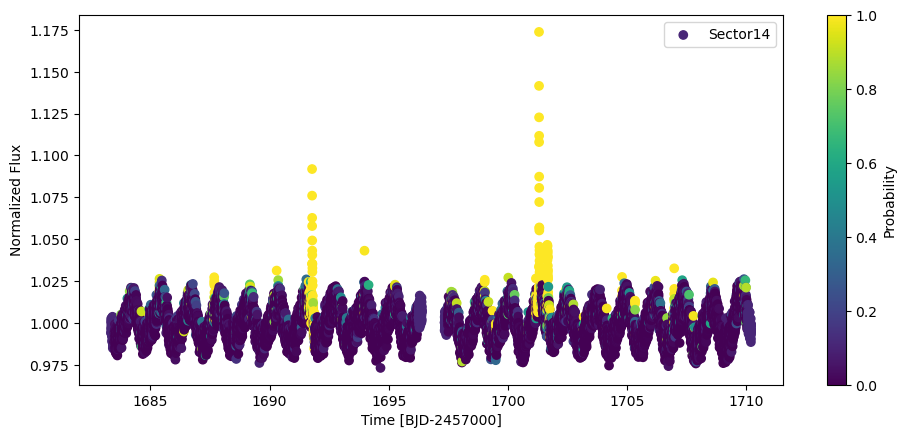

/Users/Tobin/Dropbox/Stellar_Flares_Project/Getting_Started/FFD/FFD.py:55: RuntimeWarning: invalid value encountered in log10
  ffd_x = np.log10(ED[ss]) + Lum


Can only use stella.ConvNN.predict().



  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


100%|████████████████| 1/1 [00:01<00:00,  1.26s/it]


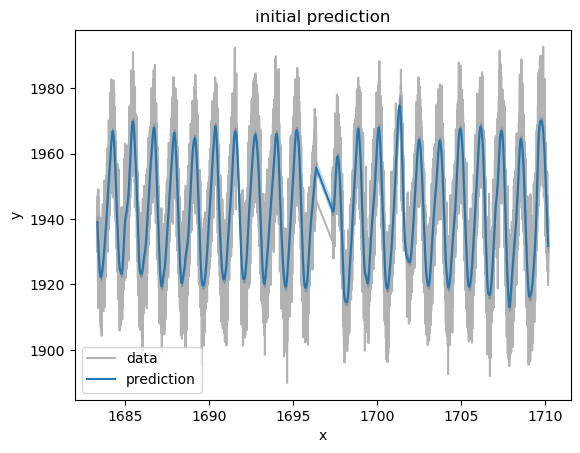

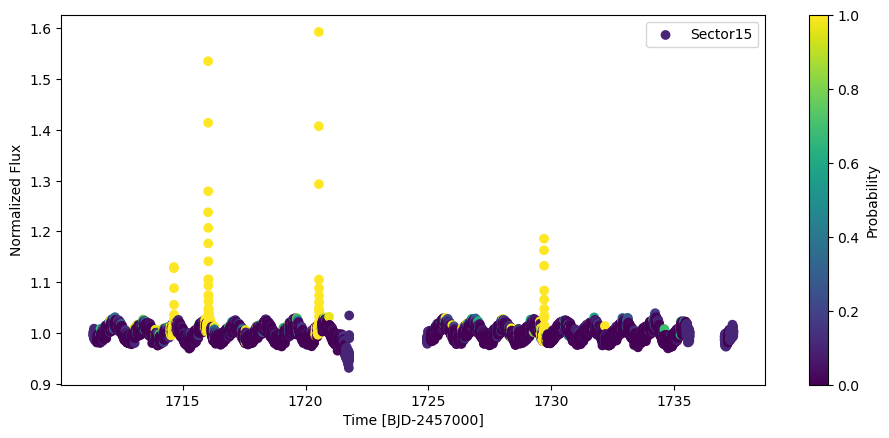

Can only use stella.ConvNN.predict().



  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 2s 3ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 3s 5ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 2s 3ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 2s 3ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 2s 3ms/step


100%|████████████████| 1/1 [00:02<00:00,  2.28s/it]


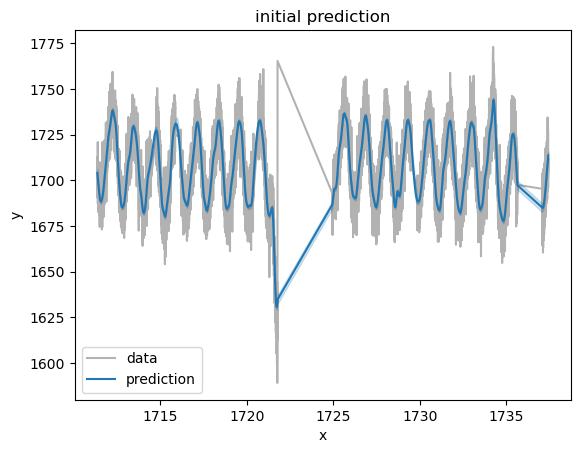

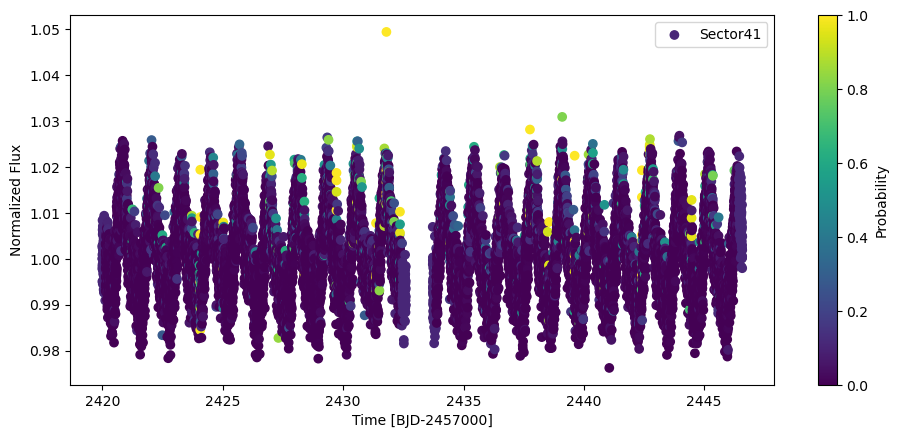

Can only use stella.ConvNN.predict().



  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


100%|████████████████| 1/1 [00:01<00:00,  1.62s/it]


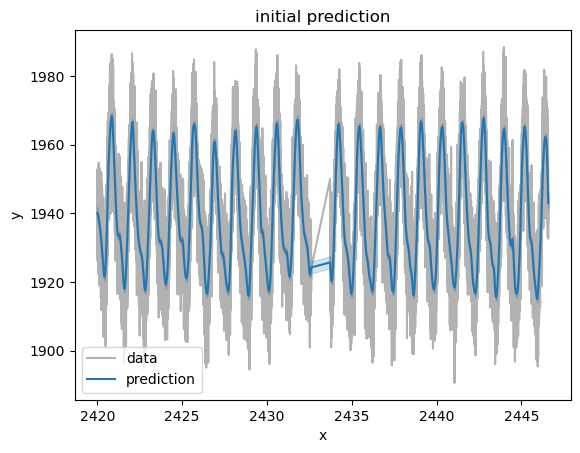

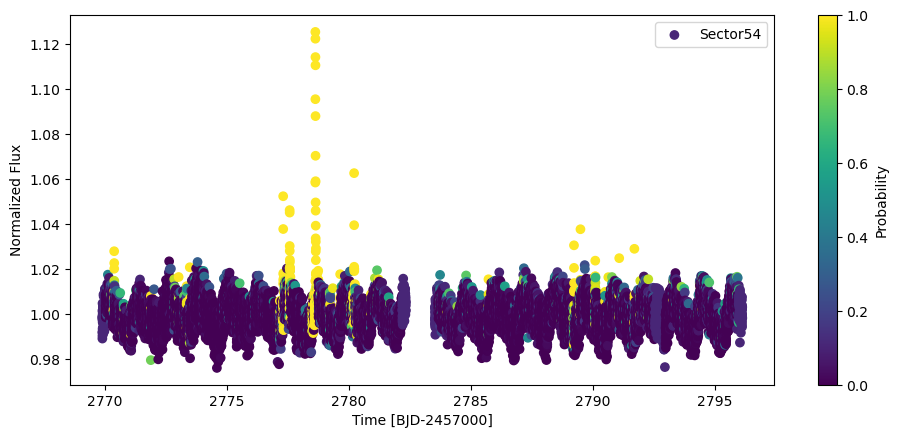

Can only use stella.ConvNN.predict().



  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                        | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


100%|████████████████| 1/1 [00:01<00:00,  1.66s/it]


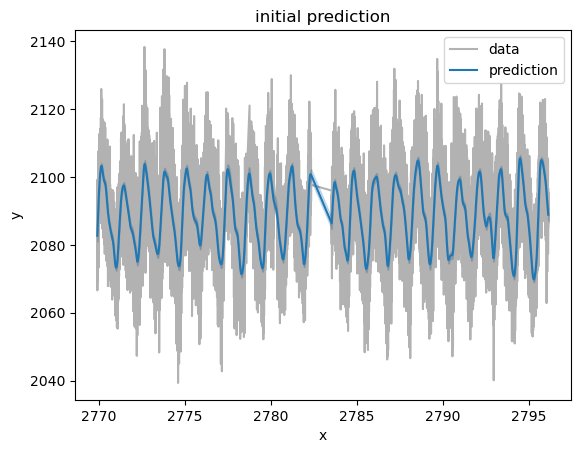

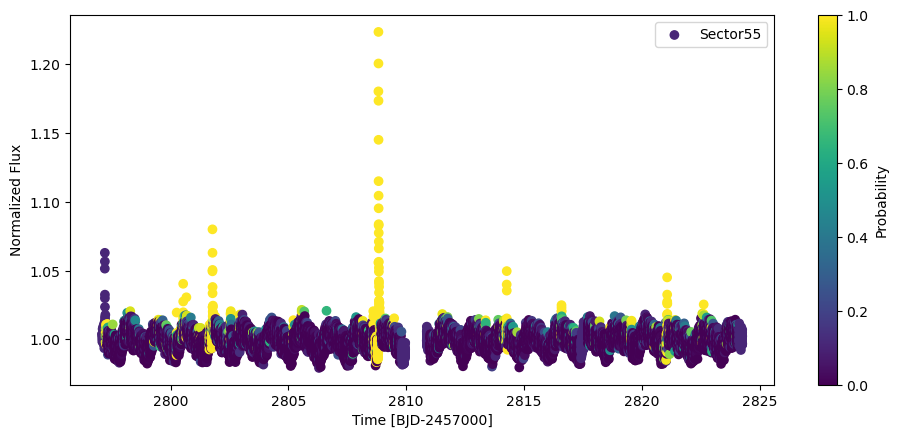

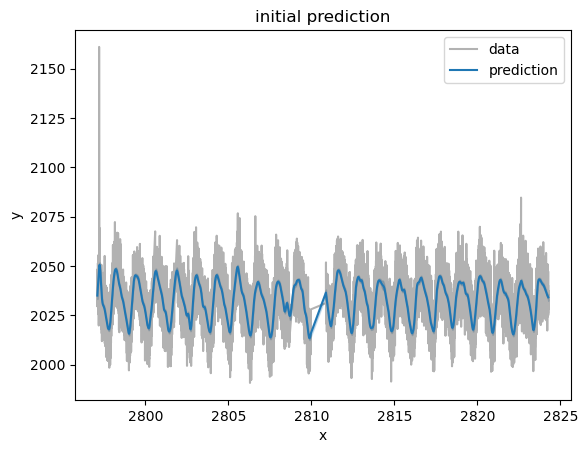

In [11]:
sector_specific_energies=[]
sector_specific_rates=[]
energy_errors=[]
rate_errors=[]

flare_starts_list=[]
flare_stops_list=[]

EDs_list=[]

flare_bool_list=[]

for i in range(len(lcs)):
    x, y, xe, ye, flare_starts, flare_stops, bools, EDs = putting_it_all_together(lcs[i])
    
    sector_specific_energies.append(x)
    sector_specific_rates.append(y)
    energy_errors.append(xe)
    rate_errors.append(ye)
    
    flare_starts_list.append(flare_starts)
    flare_stops_list.append(flare_stops)
    flare_bool_list.append(bools)
    EDs_list.append(EDs)


In [12]:
sector_specific_energies

[array([32.30735842, 32.13226474, 32.07092712, 31.47483109, 31.40080005,
        30.6756013 , 30.56325326, 30.5604899 , 30.54347887, 30.53987341,
        30.51010957, 30.49926235, 30.48124241, 30.37249224, 30.35876042,
        30.35349823, 30.30797845, 30.25794974, 30.23686619, 30.21281213,
        30.17514144, 29.84161093, 29.79359472, 29.64520858, 29.64215336,
        29.6271037 , 29.62252512, 29.45376583, 29.4320204 , 29.31941122,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan]),
 array([32.59165793, 32.48375417, 31.87603994, 31.74381469, 31.09681088,
        30.96977293, 30.88499904, 30.70492955, 30.58019893, 30.554429  ,
        30.52444776, 30.48220138, 30.42511618, 30.36026649, 30.30512197,
        30.26434786, 30.20907242, 30.13523247, 29.88684353, 29.83299031,
        29.7131

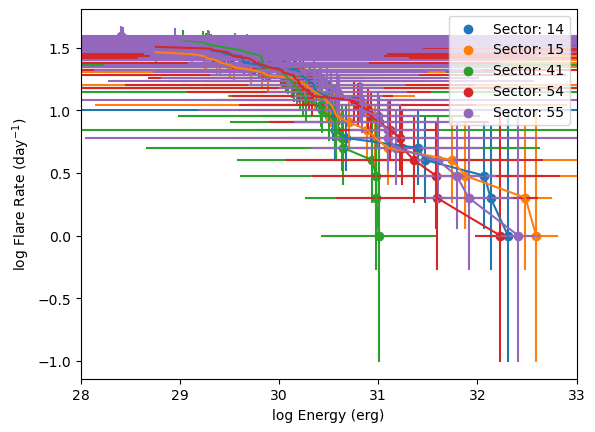

In [13]:
sectors=[int(mission[-2:]) for mission in search.mission]



for i in range(len(sector_specific_energies)):
    plt.scatter(sector_specific_energies[i], sector_specific_rates[i], label=('Sector: '+str(sectors[i])))
    plt.errorbar(sector_specific_energies[i], sector_specific_rates[i], xerr=energy_errors[i], yerr=rate_errors[i])
    plt.xlabel('log Energy (erg)')
    plt.ylabel('log Flare Rate (day$^{-1}$)')
    plt.xlim(28,33)
    plt.legend()


#### Next plot

median sector_time vs log(Sum of all ED's for single sector / total duration for sector (in seconds))

In [14]:
EDs_list

[array([ 2.41489067e-06, -6.32452550e-06,  4.23388944e-05,  4.01198843e-05,
        -5.10172740e-06, -1.40788718e-05,  4.90444600e-06,  2.91263663e-04,
         5.11322420e-06,  3.12972846e-06,  4.20703531e-05,  7.19583136e-06,
        -2.48065389e-06,  3.50532807e-05,  2.61206808e-05, -2.06970095e-05,
         1.36274118e-03,  3.74624195e-05, -4.95585320e-06, -7.51349139e-06,
        -1.67701208e-05, -4.60323002e-06,  2.72884268e-05,  2.64391005e-05,
         5.48387510e-05, -4.66267664e-06, -4.88000595e-06, -4.60393801e-06,
         4.85301217e-06,  3.65383230e-05,  1.56946268e-03,  1.88928895e-05,
         2.34879265e-03,  5.07737946e-06, -7.57408220e-06,  8.03705967e-06,
         2.35214834e-05, -3.05525004e-05, -3.52794222e-06,  1.99688220e-05,
         1.73231832e-05,  4.04543410e-05, -2.47971858e-05,  3.45396033e-04,
         2.09621586e-05,  3.29042569e-06, -7.80334353e-07]),
 array([ 3.66770426e-06,  1.44642906e-04, -4.85652888e-05,  4.14873079e-05,
         3.87198814e-05,  2

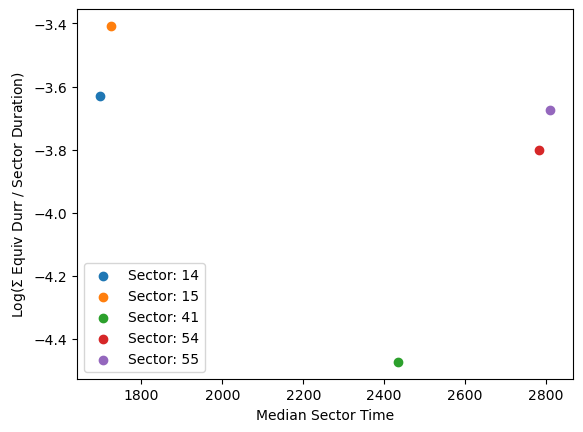

In [15]:
for i in range(len(sector_specific_energies)):
    total_dur=(lcs[i]['time'][-1].value-lcs[i]['time'][0].value)*u.day
    total_dur=(total_dur.to(u.s)).value
    
    plt.scatter(np.median(lcs[i]['time'].value), np.log10(np.sum(EDs_list[i]*86400) / total_dur), 
                                           label=('Sector: '+str(sectors[i])))
                
    plt.ylabel('Log($\Sigma$ Equiv Durr / Sector Duration)')
    plt.xlabel('Median Sector Time')
    #plt.xlim(28,33)
    plt.legend()

Change y axis to log(L_{flare}/L_{Quies})

Add units to x axis

Color of data points (Jim doesn't know yet)

#### Big Next Steps:

- Make updates version of the 5 panel 

- Save all the flares prop:
    - Start, Stop times, ED's 

- Fitting Flare Frequency diagrams with power law models
    - either fit for the intercept and slope, or fix the slope to 1 and only measure the intercept
    

In [16]:
Dict= {}

Dict["Sector_Energies"] = sector_specific_energies

Dict["Sector_Rates"] = sector_specific_rates

Dict["Energy_Errors"] = energy_errors

Dict["Rate_Errors"] = rate_errors

Dict["Flare_Starts"] = flare_starts_list
Dict["Flare_Stops"] = flare_stops_list

Dict["Flare_Bool"] = flare_bool_list

Dict["Equivilant_Durations"] = EDs_list

Dict

{'Sector_Energies': [array([32.30735842, 32.13226474, 32.07092712, 31.47483109, 31.40080005,
         30.6756013 , 30.56325326, 30.5604899 , 30.54347887, 30.53987341,
         30.51010957, 30.49926235, 30.48124241, 30.37249224, 30.35876042,
         30.35349823, 30.30797845, 30.25794974, 30.23686619, 30.21281213,
         30.17514144, 29.84161093, 29.79359472, 29.64520858, 29.64215336,
         29.6271037 , 29.62252512, 29.45376583, 29.4320204 , 29.31941122,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan]),
  array([32.59165793, 32.48375417, 31.87603994, 31.74381469, 31.09681088,
         30.96977293, 30.88499904, 30.70492955, 30.58019893, 30.554429  ,
         30.52444776, 30.48220138, 30.42511618, 30.36026649, 30.30512197,
         30.26434786, 30.20907242, 30.13523247, 29.88684

In [17]:
import pickle

with open('Energies_and_rates.pkl', 'wb') as f:
    pickle.dump(Dict, f)

In [18]:
def line(x, m, b):
    return m*x + b



In [20]:
len(Dict['Flare_Bool'][3])

17898

In [46]:
from scipy.optimize import curve_fit

intercepts=np.zeros((len(sector_specific_energies)))
slopes=np.zeros((len(sector_specific_energies)))

for i in range(len(sector_specific_energies)):
    params, var= curve_fit(line, sector_specific_energies[i][~np.isnan(sector_specific_energies[i])],
                          sector_specific_rates[i][~np.isnan(sector_specific_energies[i])])
    
    slopes[i]= params[0]
    intercepts[i]=params[1]
    
slopes

array([-0.45310628, -0.37272042, -0.66746943, -0.44336754, -0.40907457])

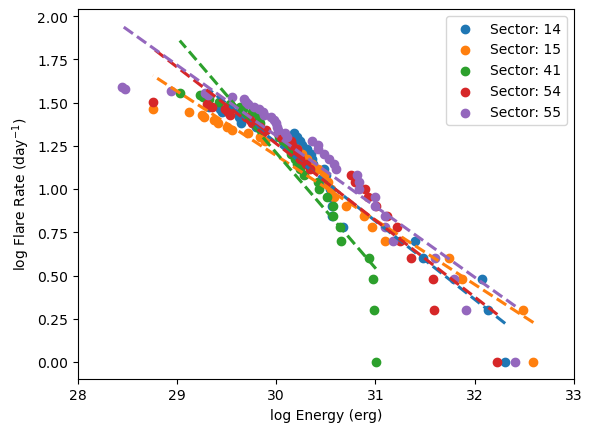

In [47]:
for i in range(len(sector_specific_energies)):
    plt.scatter(sector_specific_energies[i], sector_specific_rates[i], label=('Sector: '+str(sectors[i])))
    plt.plot(sector_specific_energies[i], line(sector_specific_energies[i], slopes[i], intercepts[i]),
             linewidth=2.2, linestyle='--')
    plt.xlabel('log Energy (erg)')
    plt.ylabel('log Flare Rate (day$^{-1}$)')
    plt.xlim(28,33)
    plt.legend()

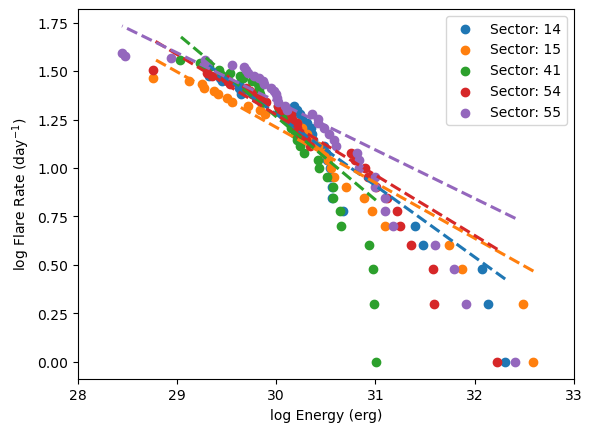

In [48]:
#With Errors
from scipy.optimize import curve_fit

intercepts=np.zeros((len(sector_specific_energies)))
slopes=np.zeros((len(sector_specific_energies)))

for i in range(len(sector_specific_energies)):
    params, var= curve_fit(line, sector_specific_energies[i][~np.isnan(sector_specific_energies[i])],
                          sector_specific_rates[i][~np.isnan(sector_specific_energies[i])], 
                           sigma=rate_errors[i][~np.isnan(sector_specific_energies[i])], absolute_sigma=True)
    
    slopes[i]= params[0]
    intercepts[i]=params[1]
    
slopes

for i in range(len(sector_specific_energies)):
    plt.scatter(sector_specific_energies[i], sector_specific_rates[i], label=('Sector: '+str(sectors[i])))
    plt.plot(sector_specific_energies[i], line(sector_specific_energies[i], slopes[i], intercepts[i]),
             linewidth=2.2, linestyle='--')
    plt.xlabel('log Energy (erg)')
    plt.ylabel('log Flare Rate (day$^{-1}$)')
    plt.xlim(28,33)
    plt.legend()

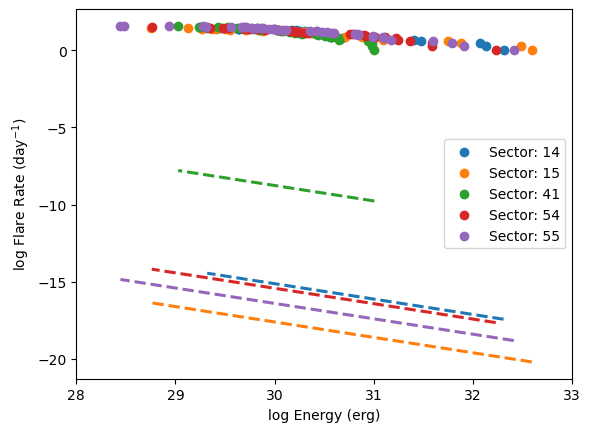

In [40]:
#Same thing but fixing the slope:

def line_fs(x,  b):
    return -x + b

intercepts_fs=np.zeros((len(sector_specific_energies)))
slopes_fs=np.zeros((len(sector_specific_energies)))

for i in range(len(sector_specific_energies)):
    params_fs, var_fs= curve_fit(line, sector_specific_energies[i][~np.isnan(sector_specific_energies[i])],
                          sector_specific_rates[i][~np.isnan(sector_specific_energies[i])])
    
    slopes_fs[i]= params_fs[0]
    intercepts_fs[i]=params_fs[1]
    
for i in range(len(sector_specific_energies)):
    plt.scatter(sector_specific_energies[i], sector_specific_rates[i], label=('Sector: '+str(sectors[i])))
    plt.plot(sector_specific_energies[i], line(sector_specific_energies[i], -1, intercepts_fs[i]),
             linewidth=2.2, linestyle='--')
    plt.xlabel('log Energy (erg)')
    plt.ylabel('log Flare Rate (day$^{-1}$)')
    plt.xlim(28,33)
    plt.legend()

#### Next Step

Create a bunch of fake flares, and insert into the light curve

Best way, insert 1 flare per light curve 


Just Re-run the Stella bit.

- Generate 1000 flares with different energies, insert at random points on the masked data (not where real flares are), 
- Do for every sector 
- Can assign the Nans to be 10^{28} 

- Use Lupitas flare model, (Lupita+ 22)

- Make FFD